<a href="https://colab.research.google.com/github/vamsigp/EIP-4/blob/master/wk-5/resent/W5_PersonAttributes_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG-16 isnt improving with Image Augmentation as well; 
so trail with Resnet and Image Augmentation

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
import numpy as np

from keras.applications import VGG16, VGG19
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import SeparableConv2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from keras.applications.resnet50 import ResNet50

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

import os

In [6]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

gender imagequality    age  ...        emotion        bodypose     image_path
0    male      Average  35-45  ...        Neutral  Front-Frontish  resized/1.jpg
1  female      Average  35-45  ...  Angry/Serious  Front-Frontish  resized/2.jpg
2    male         Good  45-55  ...        Neutral  Front-Frontish  resized/3.jpg
3    male         Good  45-55  ...        Neutral  Front-Frontish  resized/4.jpg
4  female         Good  35-45  ...        Neutral  Front-Frontish  resized/5.jpg

[5 rows x 9 columns]

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

In [8]:
one_hot_df.head(10).T

0  ...               9
image_path                            resized/1.jpg  ...  resized/10.jpg
gender_female                                     0  ...               0
gender_male                                       1  ...               1
imagequality_Average                              1  ...               1
imagequality_Bad                                  0  ...               0
imagequality_Good                                 0  ...               0
age_15-25                                         0  ...               0
age_25-35                                         0  ...               1
age_35-45                                         1  ...               0
age_45-55                                         0  ...               0
age_55+                                           0  ...               0
weight_normal-healthy                             1  ...               0
weight_over-weight                                0  ...               0
weight_slightly-overweight                        0  ...               0
weight_underweight                                0  ...               1
carryingbag_Daily/Office/Work Bag                 0  ...               1
carryingbag_Grocery/Home/Plastic Bag              1  ...               0
carryingbag_None                                  0  ...               0
footwear_CantSee                                  0  ...               0
footwear_Fancy                                    0  ...               1
footwear_Normal                                   1  ...               0
emotion_Angry/Serious                             0  ...               0
emotion_Happy                                     0  ...               0
emotion_Neutral                                   1  ...               1
emotion_Sad                                       0  ...               0
bodypose_Back                                     0  ...               0
bodypose_Front-Frontish                           1  ...               1
bodypose_Side                                     0  ...               0

[28 rows x 10 columns]

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
col_list = [_gender_cols_, _imagequality_cols_, _age_cols_, _weight_cols_, _carryingbag_cols_, _footwear_cols_, _emotion_cols_, _bodypose_cols_]

In [11]:
for row in (col_list):
  print(row)

['gender_female', 'gender_male']
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
['bodypose_Back', 'bodypose_Front-Frontish', 'bodypose_Side']


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def create_ImageData_generator(cutout=True):

  pixel_level = False
  if not cutout:
    cutout_fn = None
  else:
    cutout_fn = get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level)

  datagen1 = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
    )

  datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          # zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=20,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.1,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=cutout_fn,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)
  return datagen1

Data generator
* Can use Image Augmentation (CutOut) for the Training Images
* Image Augmentation should not be used for Validation Images

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    image_aug = False
    image_aug_method = create_ImageData_generator(cutout=False)

    def __init__(self, df, batch_size=32, shuffle=True, image_aug=False):
        self.image_aug = image_aug
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        if self.image_aug:
          images = self.image_aug_method.flow(images, shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [15]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=41)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [16]:
train_df.head()

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
4271    resized/4272.jpg              0  ...                        0              0
13191  resized/13193.jpg              1  ...                        1              0
4353    resized/4354.jpg              1  ...                        1              0
6923    resized/6924.jpg              0  ...                        1              0
3245    resized/3246.jpg              0  ...                        1              0

[5 rows x 28 columns]

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11537 entries, 4271 to 1984
Data columns (total 28 columns):
image_path                              11537 non-null object
gender_female                           11537 non-null uint8
gender_male                             11537 non-null uint8
imagequality_Average                    11537 non-null uint8
imagequality_Bad                        11537 non-null uint8
imagequality_Good                       11537 non-null uint8
age_15-25                               11537 non-null uint8
age_25-35                               11537 non-null uint8
age_35-45                               11537 non-null uint8
age_45-55                               11537 non-null uint8
age_55+                                 11537 non-null uint8
weight_normal-healthy                   11537 non-null uint8
weight_over-weight                      11537 non-null uint8
weight_slightly-overweight              11537 non-null uint8
weight_underweight                

In [18]:
val_df.head()

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
10129  resized/10130.jpg              0  ...                        0              1
12080  resized/12082.jpg              1  ...                        1              0
7908    resized/7909.jpg              0  ...                        1              0
12261  resized/12263.jpg              0  ...                        1              0
6583    resized/6584.jpg              1  ...                        0              1

[5 rows x 28 columns]

In [19]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 10129 to 6859
Data columns (total 28 columns):
image_path                              2036 non-null object
gender_female                           2036 non-null uint8
gender_male                             2036 non-null uint8
imagequality_Average                    2036 non-null uint8
imagequality_Bad                        2036 non-null uint8
imagequality_Good                       2036 non-null uint8
age_15-25                               2036 non-null uint8
age_25-35                               2036 non-null uint8
age_35-45                               2036 non-null uint8
age_45-55                               2036 non-null uint8
age_55+                                 2036 non-null uint8
weight_normal-healthy                   2036 non-null uint8
weight_over-weight                      2036 non-null uint8
weight_slightly-overweight              2036 non-null uint8
weight_underweight                      2036 non

#### create Data gnerators

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,image_aug=None)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [23]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
# plt.imshow(images[0])
for key in targets.keys():
  targets.get('key')

In [25]:
targets.get('gender_output')[0]

array([1, 0], dtype=uint8)

#### Training Data Visualization

In [26]:


plt.clf()
plt.style.use('seaborn-muted')

<Figure size 432x288 with 0 Axes>

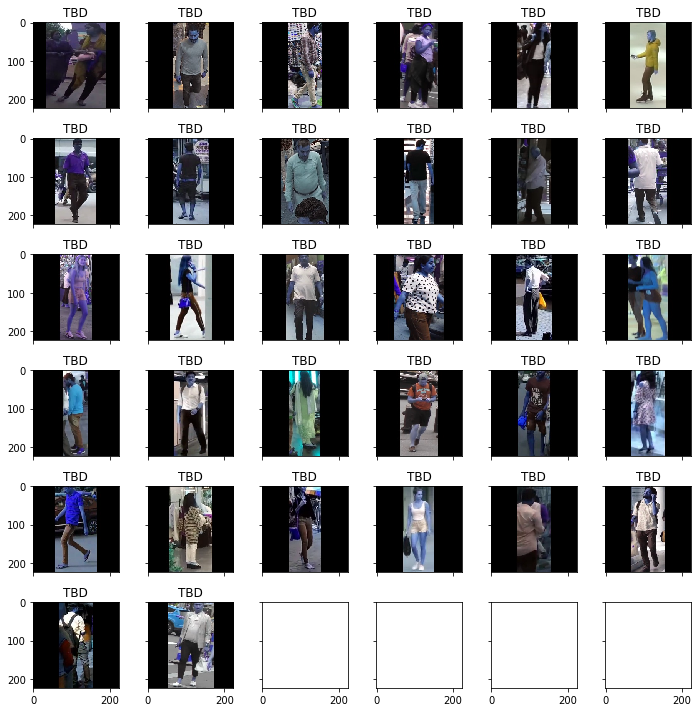

In [28]:
fig, axes = plt.subplots(6,6, figsize=(10,10),sharex=True, sharey=True, subplot_kw=dict(adjustable='box', aspect='equal'))

for i in range(len(images)):
  subplot_row = i//6
  subplot_col = i%6 
  ax = axes[subplot_row, subplot_col]
  ax.imshow(images[i])#, cmap='gray')
  ax.set_title('TBD')

plt.tight_layout()
plt.show()

In [0]:
def plot_model_history(model_history):
    acc = ['gender_output_acc', 'image_quality_output_acc' , 'age_output_acc', 'weight_output_acc','bag_output_acc', 'footwear_output_acc','pose_output_acc',  'emotion_output_acc']
    val_acc = ['val_gender_output_acc', 'val_image_quality_output_acc' , 'val_age_output_acc', 'val_weight_output_acc','val_bag_output_acc', 'val_footwear_output_acc','val_pose_output_acc',  'val_emotion_output_acc']
    loss = ['gender_output_loss', 'image_quality_output_loss' , 'age_output_loss', 'weight_output_loss','bag_output_loss', 'footwear_output_loss','pose_output_loss',  'emotion_output_loss']
    val_loss = ['val_gender_output_loss', 'val_image_quality_output_loss' , 'val_age_output_loss', 'val_weight_output_loss','val_bag_output_loss', 'val_footwear_output_loss','val_pose_output_loss',  'val_emotion_output_loss']
    fig, axs = plt.subplots(8,2,figsize=(25,25))
    for i in range(8) :
      axs[i][0].plot(range(1,len(model_history.history[acc[i]])+1),model_history.history[acc[i]])
      axs[i][0].plot(range(1,len(model_history.history[val_acc[i]])+1),model_history.history[val_acc[i]])
      axs[i][0].set_title(acc[i])
      
      axs[i][0].set_xticks(np.arange(1,len(model_history.history[val_acc[i]])+1),len(model_history.history[val_acc[i]])/10)
      axs[i][0].legend(['train', 'val'], loc='best')
      # summarize history for loss
      axs[i][1].plot(range(1,len(model_history.history[loss[i]])+1),model_history.history[loss[i]])
      axs[i][1].plot(range(1,len(model_history.history[val_loss[i]])+1),model_history.history[val_loss[i]])
      axs[i][1].set_title(loss[i])
      
      axs[i][1].set_xticks(np.arange(1,len(model_history.history[loss[i]])+1),len(model_history.history[loss[i]])/10)
      axs[i][1].legend(['train', 'val'], loc='best')

    plt.show()

#### Resnet

### Model Creation - Resnet 50

In [30]:
# backbone = VGG16(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

# backbone = VGG19(
#     weights=None, 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

# load model
backbone = ResNet50(weights= None, include_top=False, input_tensor=Input(shape=(224,224,3)))

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)
#vk
neck = BatchNormalization()(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    return neck


def build_head(name, in_layer):
    x = Dense(num_units[name], activation="softmax", name=f"{name}_output")(in_layer)
    return x

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Training from scratch, so need to train all the layers of VGG-16

In [0]:
# freeze backbone
# VK
# for layer in backbone.layers:
# 	layer.trainable = False

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def update_callbacks():

  # Prepare model model saving directory.
  # save_dir = os.path.join(os.getcwd(), 'saved_models')
  save_dir = F"/content/gdrive/My Drive/w5_models_resnet_1" 
  model_name = 'Wk5_model.{epoch:03d}.h5'
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # Prepare callbacks for model saving and for learning rate adjustment.
  checkpoint = ModelCheckpoint(filepath=filepath,
                              # monitor='val_acc',
                              verbose=1,
                              save_best_only=True)

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                min_lr=0.5e-6)

  callbacks = [checkpoint, lr_reducer, lr_scheduler]
  # VK - check usage of other callbacks
  # callbacks = [lr_reducer,lr_scheduler]

  return callbacks

In [34]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss=losses, 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

#### Model Run (First)

In [0]:
train_history = model.fit_generator(generator=train_gen, validation_data=valid_gen, 
                                    use_multiprocessing=True,
                                    callbacks = update_callbacks(),
                                    workers=8, epochs=50,verbose=1)



Epoch 1/50
Learning rate:  0.001
360/360 [==============================] - 126s 350ms/step - loss: 9.0903 - gender_output_loss: 0.7518 - image_quality_output_loss: 1.1244 - age_output_loss: 1.6214 - weight_output_loss: 1.1961 - bag_output_loss: 1.0722 - footwear_output_loss: 1.1288 - pose_output_loss: 1.0667 - emotion_output_loss: 1.1287 - gender_output_acc: 0.5305 - image_quality_output_acc: 0.4667 - age_output_acc: 0.3027 - weight_output_acc: 0.5371 - bag_output_acc: 0.4739 - footwear_output_acc: 0.4454 - pose_output_acc: 0.5246 - emotion_output_acc: 0.6037 - val_loss: 7.8969 - val_gender_output_loss: 0.6747 - val_image_quality_output_loss: 1.0011 - val_age_output_loss: 1.4472 - val_weight_output_loss: 1.0140 - val_bag_output_loss: 0.9263 - val_footwear_output_loss: 0.9743 - val_pose_output_loss: 0.9388 - val_emotion_output_loss: 0.9205 - val_gender_output_acc: 0.5605 - val_image_quality_output_acc: 0.5418 - val_age_output_acc: 0.4098 - val_weight_output_acc: 0.6215 - val_bag_outp

#### Model evalluation

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)

31/31 [==============================] - 5s 152ms/step


In [0]:
dict(zip(model.metrics_names, results))

{'age_output_acc': 0.39868951612903225,
 'age_output_loss': 1.4081979951550883,
 'bag_output_acc': 0.5655241935483871,
 'bag_output_loss': 0.896796295719762,
 'emotion_output_acc': 0.7227822580645161,
 'emotion_output_loss': 0.8913928097294223,
 'footwear_output_acc': 0.5972782258064516,
 'footwear_output_loss': 0.8804590990466457,
 'gender_output_acc': 0.6824596774193549,
 'gender_output_loss': 0.5923163948520538,
 'image_quality_output_acc': 0.5463709677419355,
 'image_quality_output_loss': 0.9736666602473105,
 'loss': 7.439282309624456,
 'pose_output_acc': 0.6376008064516129,
 'pose_output_loss': 0.8341261667589988,
 'weight_output_acc': 0.6325604838709677,
 'weight_output_loss': 0.9623269208015934}

In [0]:
accuracies = {}
losses = {}
for k, v in zip(model.metrics_names, results):
    if k.endswith('acc'):
        accuracies[k] = round(v, 4)
    else:
        losses[k] = v

In [0]:
accuracies

{'age_output_acc': 0.3987,
 'bag_output_acc': 0.5655,
 'emotion_output_acc': 0.7228,
 'footwear_output_acc': 0.5973,
 'gender_output_acc': 0.6825,
 'image_quality_output_acc': 0.5464,
 'pose_output_acc': 0.6376,
 'weight_output_acc': 0.6326}

In [0]:
losses

{'age_output_loss': 1.4081979951550883,
 'bag_output_loss': 0.896796295719762,
 'emotion_output_loss': 0.8913928097294223,
 'footwear_output_loss': 0.8804590990466457,
 'gender_output_loss': 0.5923163948520538,
 'image_quality_output_loss': 0.9736666602473105,
 'loss': 7.439282309624456,
 'pose_output_loss': 0.8341261667589988,
 'weight_output_loss': 0.9623269208015934}

#### Model Accuracy

In [0]:
filtered_dict = {k:v for (k,v) in train_history.history.items() if "_acc" in k}
# filtered_dict

In [0]:
filtered_dict.keys()

dict_keys(['val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc'])

In [0]:
max_acc_dict = {}
for key in filtered_dict.keys():
  max_acc_dict[key] = max(filtered_dict.get(key))

In [0]:
import statistics
mean_acc_dict = {}
for key in filtered_dict.keys():
  mean_acc_dict[key] = statistics.mean(filtered_dict.get(key))

In [0]:
mean_acc_dict

{'age_output_acc': 0.4140434027777778,
 'bag_output_acc': 0.6004375,
 'emotion_output_acc': 0.7074079861111111,
 'footwear_output_acc': 0.630765625,
 'gender_output_acc': 0.7068854166666667,
 'image_quality_output_acc': 0.560234375,
 'pose_output_acc': 0.6795729166666666,
 'val_age_output_acc': 0.40254032258064515,
 'val_bag_output_acc': 0.5670362903225806,
 'val_emotion_output_acc': 0.7237600806451613,
 'val_footwear_output_acc': 0.5932258064516129,
 'val_gender_output_acc': 0.6634879032258064,
 'val_image_quality_output_acc': 0.543125,
 'val_pose_output_acc': 0.6340322580645161,
 'val_weight_output_acc': 0.6342641129032258,
 'weight_output_acc': 0.6387326388888889}

In [0]:
max_acc_dict

{'age_output_acc': 0.43515625,
 'bag_output_acc': 0.6270833333333333,
 'emotion_output_acc': 0.7125,
 'footwear_output_acc': 0.6671875,
 'gender_output_acc': 0.7571180555555556,
 'image_quality_output_acc': 0.575,
 'pose_output_acc': 0.7198784722222222,
 'val_age_output_acc': 0.4163306451612903,
 'val_bag_output_acc': 0.577116935483871,
 'val_emotion_output_acc': 0.7258064516129032,
 'val_footwear_output_acc': 0.609375,
 'val_gender_output_acc': 0.6875,
 'val_image_quality_output_acc': 0.5514112903225806,
 'val_pose_output_acc': 0.641633064516129,
 'val_weight_output_acc': 0.6411290322580645,
 'weight_output_acc': 0.6486111111111111}

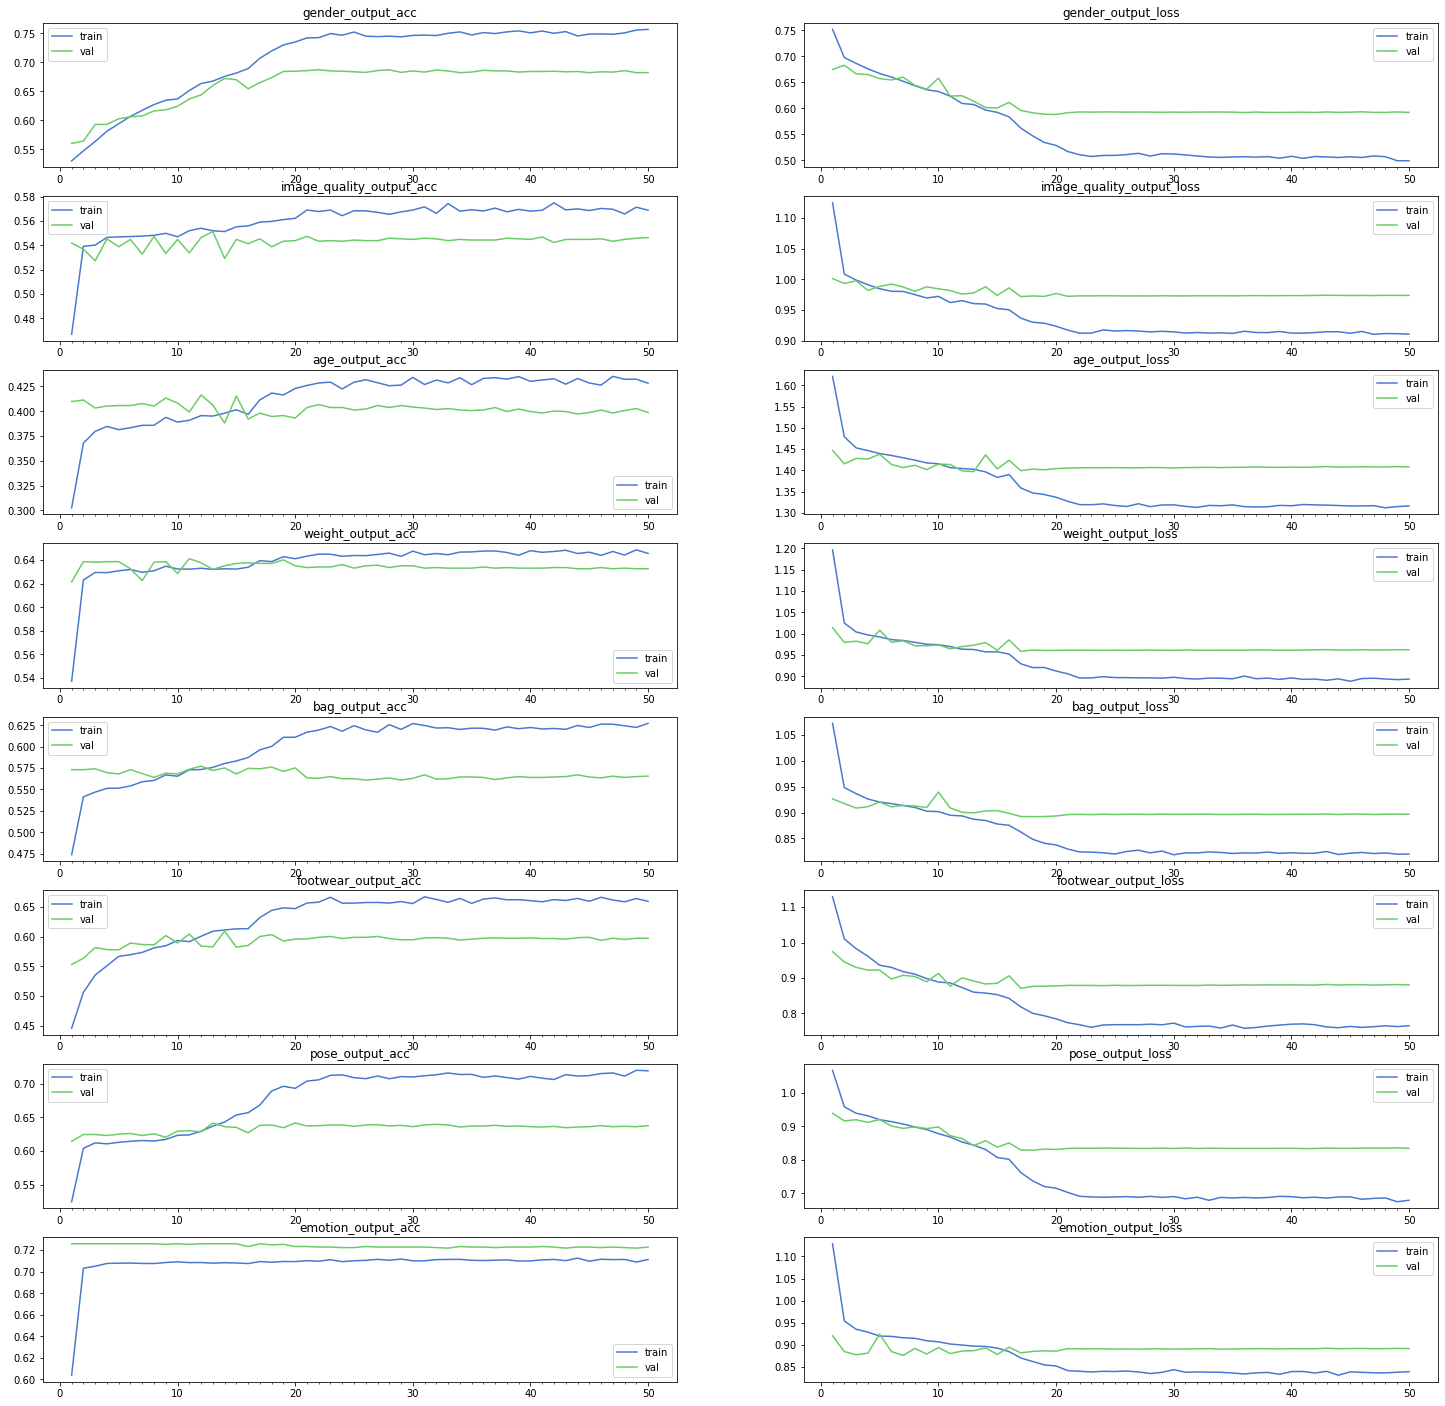

In [0]:
plot_model_history(train_history)

#### Model Summaries and Model Image

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Code for ReRun
1. Load Model
2. Evaluate Model
3. update Learning Rate
4. ReRun Model

In [0]:
import keras.backend as K
from keras.models import Model, load_model

In [0]:
def load_saved_model(dirPath):
  #path = "/content/gdrive/My Drive/saved_models/cifar10_ResNet20v1_model.047.0.9034.h5"
  save_dir = F"/content/gdrive/My Drive/"
  model_dir = os.path.join(save_dir, dirPath)

  last_best_model =  max(os.listdir(model_dir))
  last_best_model = os.path.join(model_dir, last_best_model)
  model = load_model(last_best_model)
  return model

In [0]:
def evaluate_model(model, valid_gen):
  results = model.evaluate_generator(valid_gen, verbose=1)
  accuracies = {}
  losses = {}
  for k, v in zip(model.metrics_names, results):
      if k.endswith('acc'):
          accuracies[k] = round(v, 4)
      else:
          losses[k] = v

  return accuracies, losses

In [0]:
def update_lr(model, updated_lr):
  K.set_value(model.optimizer.lr, updated_lr)

In [0]:
def update_callbacks_rerun(dirPath):
  save_dir = F"/content/gdrive/My Drive/"
  model_dir = os.path.join(save_dir, dirPath)

  if not os.path.isdir(model_dir):
      os.makedirs(model_dir)

  model_name = 'Wk5_model.{epoch:03d}.h5'
  filepath = os.path.join(model_dir, model_name)

  checkpoint = ModelCheckpoint(filepath=filepath, verbose=1,save_best_only=True)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6)

  return [checkpoint, lr_reducer]

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    image_aug_method = None

    def __init__(self, df, image_aug_method = None, batch_size=32, shuffle=True):
        self.image_aug_method = image_aug_method
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        if self.image_aug_method is not None:
          images = self.image_aug_method.flow(images, shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
def run_model(modelSavedPath, dirPath, updated_lr, train_gen=train_gen, valid_gen=valid_gen,epochs = 50):
  model = load_saved_model(modelSavedPath)

  update_lr(model, updated_lr)

  callbacks = update_callbacks_rerun(dirPath)

  train_history = model.fit_generator(generator=train_gen, 
                                      validation_data=valid_gen, 
                                      use_multiprocessing=True,
                                      callbacks = callbacks,
                                      workers=8, 
                                      epochs=epochs,                                    
                                      verbose=1)
  
  return train_history, model

#### Trail - 2

In [0]:
hist, m = run_model("w5_models_resnet_1", "w5_resnet_2", 1e-3)

Epoch 1/50
359/360 [============================>.] - ETA: 0s - loss: 7.1999 - gender_output_loss: 0.5699 - image_quality_output_loss: 0.9477 - age_output_loss: 1.3758 - weight_output_loss: 0.9430 - bag_output_loss: 0.8671 - footwear_output_loss: 0.8337 - pose_output_loss: 0.7805 - emotion_output_loss: 0.8821 - gender_output_acc: 0.6982 - image_quality_output_acc: 0.5538 - age_output_acc: 0.4031 - weight_output_acc: 0.6358 - bag_output_acc: 0.5947 - footwear_output_acc: 0.6212 - pose_output_acc: 0.6638 - emotion_output_acc: 0.7072

360/360 [==============================] - 123s 341ms/step - loss: 7.1992 - gender_output_loss: 0.5697 - image_quality_output_loss: 0.9477 - age_output_loss: 1.3760 - weight_output_loss: 0.9430 - bag_output_loss: 0.8668 - footwear_output_loss: 0.8339 - pose_output_loss: 0.7804 - emotion_output_loss: 0.8817 - gender_output_acc: 0.6983 - image_quality_output_acc: 0.5539 - age_output_acc: 0.4030 - weight_output_acc: 0.6357 - bag_output_acc: 0.5949 - footwear_ou

##### Trail-2 Results

In [0]:
model = load_saved_model("w5_resnet_2")

In [0]:
model_acc, model_loss = evaluate_model(model, valid_gen)

31/31 [==============================] - 14s 441ms/step


In [0]:
model_acc

{'age_output_acc': 0.4239,
 'bag_output_acc': 0.6174,
 'emotion_output_acc': 0.7193,
 'footwear_output_acc': 0.6472,
 'gender_output_acc': 0.7601,
 'image_quality_output_acc': 0.566,
 'pose_output_acc': 0.7006,
 'weight_output_acc': 0.6431}

In [0]:
model_loss

{'age_output_loss': 1.33067201798962,
 'bag_output_loss': 0.8247321382645638,
 'emotion_output_loss': 0.8307673950349131,
 'footwear_output_loss': 0.7830884629680265,
 'gender_output_loss': 0.4966906491787203,
 'image_quality_output_loss': 0.9111801482016041,
 'loss': 6.780003163122362,
 'pose_output_loss': 0.7042234886077142,
 'weight_output_loss': 0.8986487888520763}

#### Trail - 3

In [0]:
hist, m = run_model("w5_resnet_2","w5_resnet_3", 0.5e-3)

Epoch 1/50
360/360 [==============================] - 129s 358ms/step - loss: 6.9291 - gender_output_loss: 0.5296 - image_quality_output_loss: 0.9282 - age_output_loss: 1.3485 - weight_output_loss: 0.9171 - bag_output_loss: 0.8461 - footwear_output_loss: 0.7934 - pose_output_loss: 0.7072 - emotion_output_loss: 0.8590 - gender_output_acc: 0.7302 - image_quality_output_acc: 0.5632 - age_output_acc: 0.4159 - weight_output_acc: 0.6424 - bag_output_acc: 0.6062 - footwear_output_acc: 0.6470 - pose_output_acc: 0.6994 - emotion_output_acc: 0.7099 - val_loss: 6.7183 - val_gender_output_loss: 0.4890 - val_image_quality_output_loss: 0.9070 - val_age_output_loss: 1.3191 - val_weight_output_loss: 0.8971 - val_bag_output_loss: 0.8208 - val_footwear_output_loss: 0.7825 - val_pose_output_loss: 0.6815 - val_emotion_output_loss: 0.8213 - val_gender_output_acc: 0.7671 - val_image_quality_output_acc: 0.5675 - val_age_output_acc: 0.4309 - val_weight_output_acc: 0.6431 - val_bag_output_acc: 0.6215 - val_foo

Process ForkPoolWorker-270:
Process ForkPoolWorker-269:
Process ForkPoolWorker-266:
Process ForkPoolWorker-271:
Process ForkPoolWorker-267:
Process ForkPoolWorker-268:
Process ForkPoolWorker-265:
Process ForkPoolWorker-272:
Traceback (most recent call last):
Process ForkPoolWorker-259:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-261:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-263:
Traceback (most recent call last):
Process ForkPoolWorker-262:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  Fi

KeyboardInterrupt: ignored

In [0]:
plot_model_history(hist)

NameError: ignored

In [0]:
_acc, _loss = evaluate_model(model, valid_gen)

31/31 [==============================] - 5s 162ms/step


In [0]:
_acc

{'age_output_acc': 0.4239,
 'bag_output_acc': 0.6174,
 'emotion_output_acc': 0.7193,
 'footwear_output_acc': 0.6472,
 'gender_output_acc': 0.7601,
 'image_quality_output_acc': 0.566,
 'pose_output_acc': 0.7006,
 'weight_output_acc': 0.6431}

In [0]:
model = load_saved_model("w5_resnet_3")
model_acc, model_loss = evaluate_model(model, valid_gen)

31/31 [==============================] - 10s 317ms/step


In [0]:
model_acc

{'age_output_acc': 0.4304,
 'bag_output_acc': 0.6371,
 'emotion_output_acc': 0.7218,
 'footwear_output_acc': 0.6653,
 'gender_output_acc': 0.7732,
 'image_quality_output_acc': 0.5706,
 'pose_output_acc': 0.7384,
 'weight_output_acc': 0.6507}

#### Trail - 4

In [0]:
hist, m = run_model("w5_resnet_3","w5_resnet_4", 1e-4, epochs=15)



Epoch 1/15
359/360 [============================>.] - ETA: 0s - loss: 6.2667 - gender_output_loss: 0.4448 - image_quality_output_loss: 0.8777 - age_output_loss: 1.2556 - weight_output_loss: 0.8468 - bag_output_loss: 0.7678 - footwear_output_loss: 0.7081 - pose_output_loss: 0.5747 - emotion_output_loss: 0.7912 - gender_output_acc: 0.7903 - image_quality_output_acc: 0.5890 - age_output_acc: 0.4633 - weight_output_acc: 0.6610 - bag_output_acc: 0.6578 - footwear_output_acc: 0.6954 - pose_output_acc: 0.7726 - emotion_output_acc: 0.7204

360/360 [==============================] - 181s 501ms/step - loss: 6.2675 - gender_output_loss: 0.4447 - image_quality_output_loss: 0.8776 - age_output_loss: 1.2560 - weight_output_loss: 0.8468 - bag_output_loss: 0.7682 - footwear_output_loss: 0.7085 - pose_output_loss: 0.5743 - emotion_output_loss: 0.7914 - gender_output_acc: 0.7903 - image_quality_output_acc: 0.5891 - age_output_acc: 0.4629 - weight_output_acc: 0.6610 - bag_output_acc: 0.6575 - footwear_

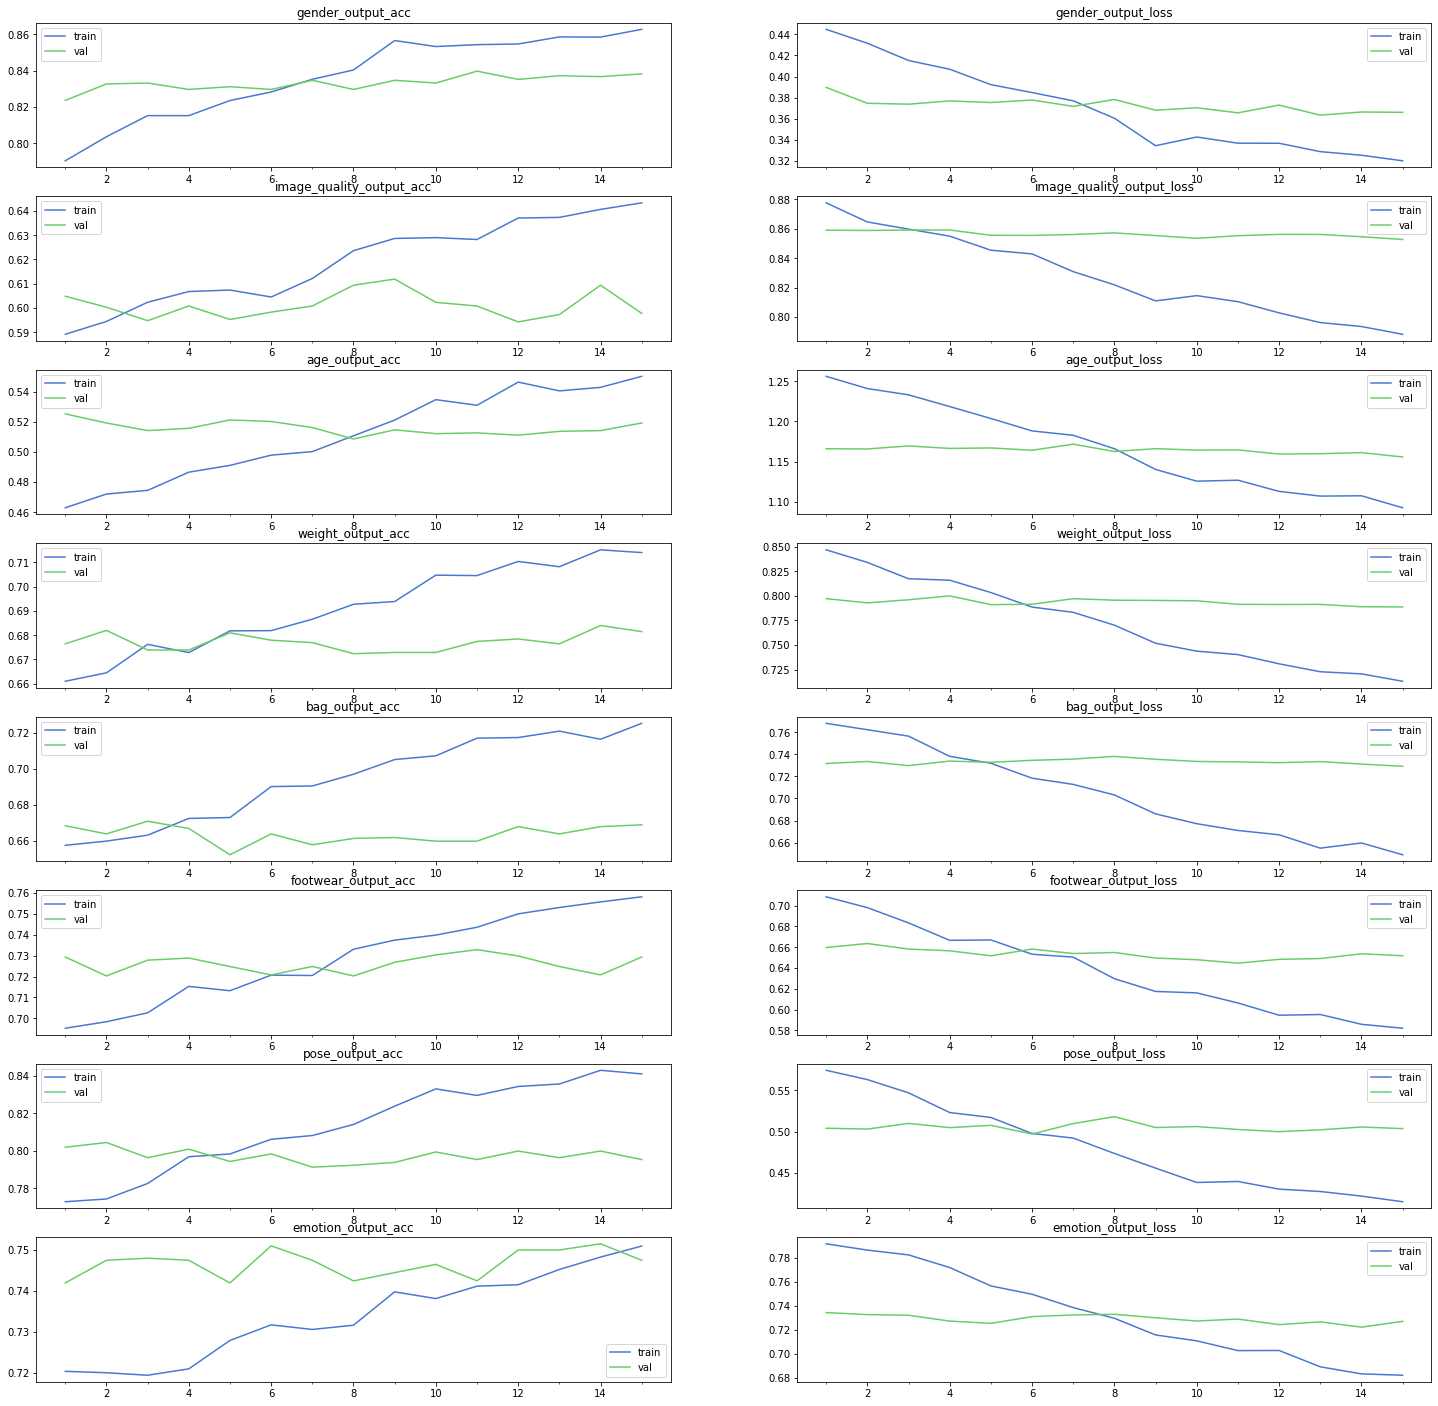

In [0]:
plot_model_history(hist)

In [0]:
_acc, _loss = evaluate_model(model, valid_gen)
_acc

31/31 [==============================] - 8s 244ms/step


{'age_output_acc': 0.1769,
 'bag_output_acc': 0.3886,
 'emotion_output_acc': 0.1195,
 'footwear_output_acc': 0.1961,
 'gender_output_acc': 0.433,
 'image_quality_output_acc': 0.1749,
 'pose_output_acc': 0.2182,
 'weight_output_acc': 0.1048}

In [0]:
model = load_saved_model("w5_resnet_4")
model_acc, model_loss = evaluate_model(model, valid_gen)
model_acc

31/31 [==============================] - 8s 271ms/step


{'age_output_acc': 0.5192,
 'bag_output_acc': 0.6689,
 'emotion_output_acc': 0.7475,
 'footwear_output_acc': 0.7293,
 'gender_output_acc': 0.8382,
 'image_quality_output_acc': 0.5978,
 'pose_output_acc': 0.7954,
 'weight_output_acc': 0.6815}

#### Trail - 5

In [0]:
datagen = ImageDataGenerator(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=20,
    # set range for random shear
    shear_range=0.1,
    # set range for random zoom
    zoom_range=0.2,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set function that will be applied on each input
    # preprocessing_function=cutout_fn,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,image_aug_method=datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
hist, m = run_model("w5_resnet_4","w5_resnet_5", 1e-3, epochs=50,train_gen=train_gen, valid_gen=valid_gen)



Epoch 1/50
359/360 [============================>.] - ETA: 0s - loss: 7.4839 - gender_output_loss: 0.6081 - image_quality_output_loss: 0.9640 - age_output_loss: 1.3981 - weight_output_loss: 0.9705 - bag_output_loss: 0.8897 - footwear_output_loss: 0.8892 - pose_output_loss: 0.8671 - emotion_output_loss: 0.8972 - gender_output_acc: 0.6664 - image_quality_output_acc: 0.5478 - age_output_acc: 0.3962 - weight_output_acc: 0.6315 - bag_output_acc: 0.5766 - footwear_output_acc: 0.5952 - pose_output_acc: 0.6282 - emotion_output_acc: 0.7122

360/360 [==============================] - 228s 632ms/step - loss: 7.4832 - gender_output_loss: 0.6077 - image_quality_output_loss: 0.9638 - age_output_loss: 1.3979 - weight_output_loss: 0.9706 - bag_output_loss: 0.8894 - footwear_output_loss: 0.8896 - pose_output_loss: 0.8669 - emotion_output_loss: 0.8973 - gender_output_acc: 0.6668 - image_quality_output_acc: 0.5479 - age_output_acc: 0.3961 - weight_output_acc: 0.6314 - bag_output_acc: 0.5769 - footwear_

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 135 could not be retrieved. It could be because a worker has died.
  UserWarning)


359/360 [============================>.] - ETA: 0s - loss: 6.2797 - gender_output_loss: 0.4217 - image_quality_output_loss: 0.8805 - age_output_loss: 1.2542 - weight_output_loss: 0.8491 - bag_output_loss: 0.7675 - footwear_output_loss: 0.7439 - pose_output_loss: 0.5647 - emotion_output_loss: 0.7982 - gender_output_acc: 0.8060 - image_quality_output_acc: 0.5896 - age_output_acc: 0.4654 - weight_output_acc: 0.6562 - bag_output_acc: 0.6542 - footwear_output_acc: 0.6709 - pose_output_acc: 0.7684 - emotion_output_acc: 0.7163Epoch 28/50

360/360 [==============================] - 215s 598ms/step - loss: 6.2798 - gender_output_loss: 0.4223 - image_quality_output_loss: 0.8804 - age_output_loss: 1.2543 - weight_output_loss: 0.8497 - bag_output_loss: 0.7672 - footwear_output_loss: 0.7436 - pose_output_loss: 0.5649 - emotion_output_loss: 0.7974 - gender_output_acc: 0.8056 - image_quality_output_acc: 0.5894 - age_output_acc: 0.4651 - weight_output_acc: 0.6562 - bag_output_acc: 0.6545 - footwear_ou

Traceback (most recent call last):
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/que

KeyboardInterrupt: ignored

In [0]:
plot_model_history(hist)
_acc, _loss = evaluate_model(model, valid_gen)
_acc

In [0]:
model = load_saved_model("w5_resnet_5")
model_acc, model_loss = evaluate_model(model, valid_gen)
model_acc

31/31 [==============================] - 11s 371ms/step


{'age_output_acc': 0.4264,
 'bag_output_acc': 0.619,
 'emotion_output_acc': 0.7001,
 'footwear_output_acc': 0.6603,
 'gender_output_acc': 0.7757,
 'image_quality_output_acc': 0.5706,
 'pose_output_acc': 0.7389,
 'weight_output_acc': 0.6497}

#### Trail - 6

In [0]:
cutout_fn = get_random_eraser(v_l=0, v_h=1, pixel_level=False)

In [0]:
datagen = ImageDataGenerator(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=20,
    # set range for random shear
    shear_range=0.1,
    # set range for random zoom
    zoom_range=0.2,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set function that will be applied on each input
    preprocessing_function=cutout_fn,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

In [46]:
hist, m = run_model("w5_resnet_5","w5_resnet_6", 1e-3, epochs=50,train_gen=train_gen, valid_gen=valid_gen)



Epoch 1/50
360/360 [==============================] - 123s 341ms/step - loss: 6.3603 - gender_output_loss: 0.4299 - image_quality_output_loss: 0.8882 - age_output_loss: 1.2736 - weight_output_loss: 0.8654 - bag_output_loss: 0.7862 - footwear_output_loss: 0.7347 - pose_output_loss: 0.5726 - emotion_output_loss: 0.8098 - gender_output_acc: 0.8006 - image_quality_output_acc: 0.5795 - age_output_acc: 0.4518 - weight_output_acc: 0.6523 - bag_output_acc: 0.6486 - footwear_output_acc: 0.6701 - pose_output_acc: 0.7693 - emotion_output_acc: 0.7169 - val_loss: 6.3734 - val_gender_output_loss: 0.4320 - val_image_quality_output_loss: 0.9065 - val_age_output_loss: 1.2935 - val_weight_output_loss: 0.8724 - val_bag_output_loss: 0.7808 - val_footwear_output_loss: 0.7197 - val_pose_output_loss: 0.5324 - val_emotion_output_loss: 0.8362 - val_gender_output_acc: 0.7999 - val_image_quality_output_acc: 0.5822 - val_age_output_acc: 0.4395 - val_weight_output_acc: 0.6482 - val_bag_output_acc: 0.6517 - val_f

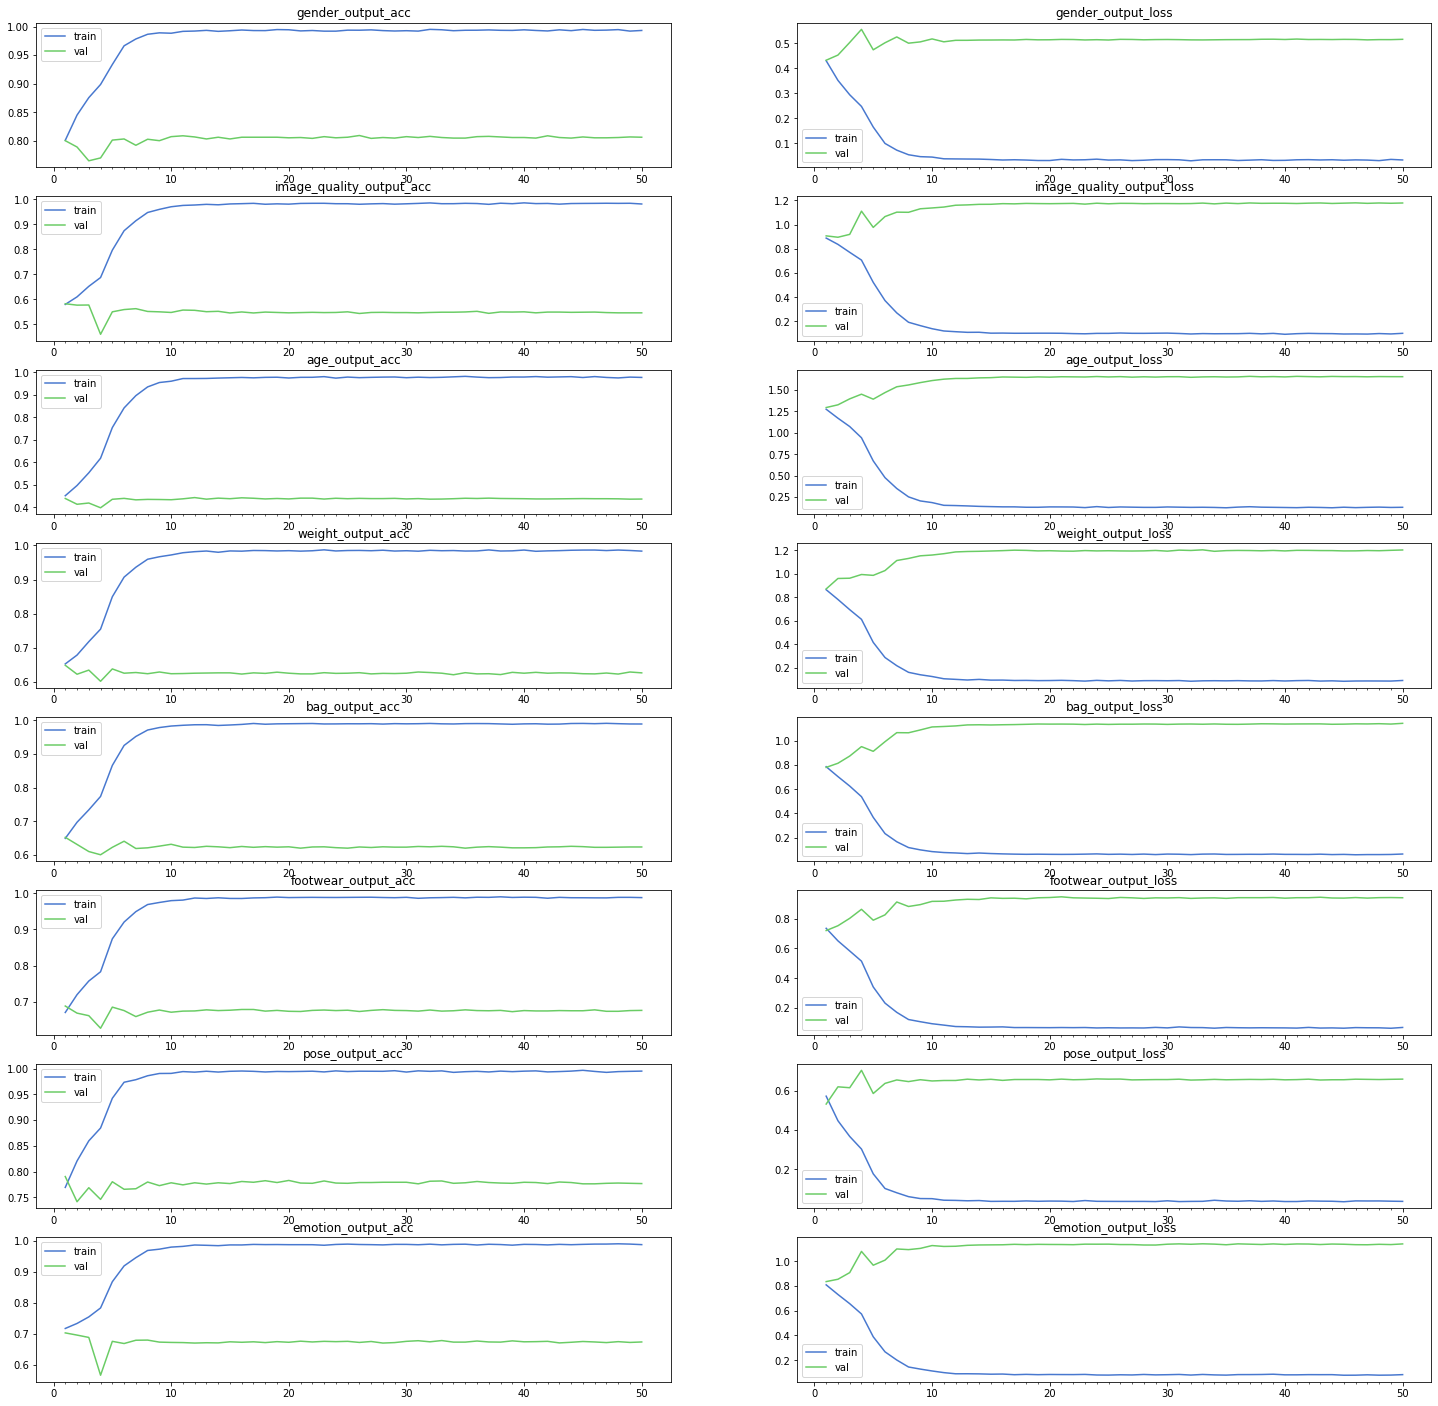

31/31 [==============================] - 7s 238ms/step


{'age_output_acc': 0.2515,
 'bag_output_acc': 0.3327,
 'emotion_output_acc': 0.0655,
 'footwear_output_acc': 0.3594,
 'gender_output_acc': 0.5635,
 'image_quality_output_acc': 0.4204,
 'pose_output_acc': 0.5202,
 'weight_output_acc': 0.1668}

In [47]:
plot_model_history(hist)
_acc, _loss = evaluate_model(model, valid_gen)
_acc

In [48]:
model = load_saved_model("w5_resnet_6")
model_acc, model_loss = evaluate_model(model, valid_gen)
model_acc

31/31 [==============================] - 8s 268ms/step


{'age_output_acc': 0.4395,
 'bag_output_acc': 0.6517,
 'emotion_output_acc': 0.7026,
 'footwear_output_acc': 0.688,
 'gender_output_acc': 0.7999,
 'image_quality_output_acc': 0.5822,
 'pose_output_acc': 0.7903,
 'weight_output_acc': 0.6482}

In [49]:
hist, m = run_model("w5_resnet_4","w5_resnet_7", 1e-4, epochs=50,train_gen=train_gen, valid_gen=valid_gen)

Epoch 1/50
360/360 [==============================] - 125s 347ms/step - loss: 5.5819 - gender_output_loss: 0.3553 - image_quality_output_loss: 0.8244 - age_output_loss: 1.1500 - weight_output_loss: 0.7631 - bag_output_loss: 0.6897 - footwear_output_loss: 0.6230 - pose_output_loss: 0.4608 - emotion_output_loss: 0.7156 - gender_output_acc: 0.8460 - image_quality_output_acc: 0.6217 - age_output_acc: 0.5207 - weight_output_acc: 0.6930 - bag_output_acc: 0.6991 - footwear_output_acc: 0.7352 - pose_output_acc: 0.8220 - emotion_output_acc: 0.7397 - val_loss: 5.0784 - val_gender_output_loss: 0.3015 - val_image_quality_output_loss: 0.7680 - val_age_output_loss: 1.0726 - val_weight_output_loss: 0.6979 - val_bag_output_loss: 0.6505 - val_footwear_output_loss: 0.5416 - val_pose_output_loss: 0.3707 - val_emotion_output_loss: 0.6756 - val_gender_output_acc: 0.8770 - val_image_quality_output_acc: 0.6633 - val_age_output_acc: 0.5464 - val_weight_output_acc: 0.7122 - val_bag_output_acc: 0.7303 - val_foo

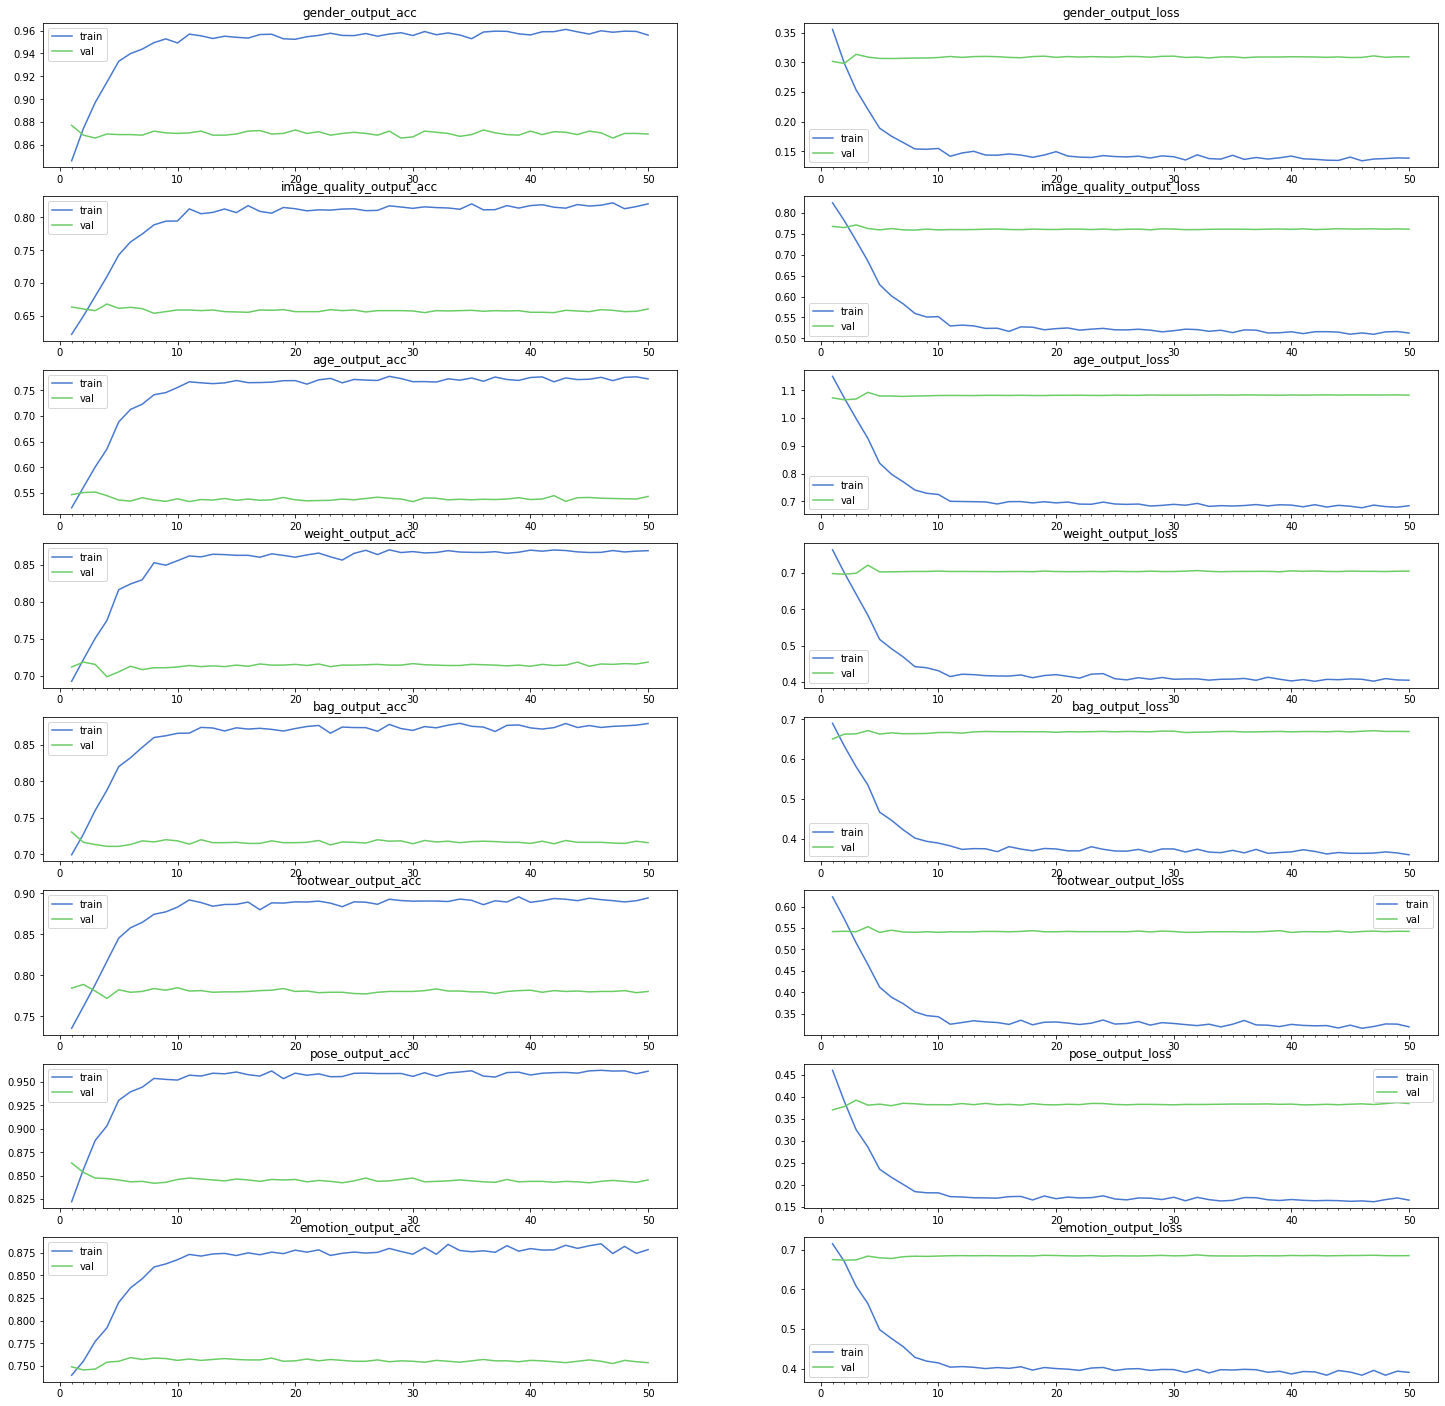

31/31 [==============================] - 5s 163ms/step


{'age_output_acc': 0.4395,
 'bag_output_acc': 0.6517,
 'emotion_output_acc': 0.7026,
 'footwear_output_acc': 0.688,
 'gender_output_acc': 0.7999,
 'image_quality_output_acc': 0.5822,
 'pose_output_acc': 0.7903,
 'weight_output_acc': 0.6482}

In [50]:
plot_model_history(hist)
_acc, _loss = evaluate_model(model, valid_gen)
_acc

In [51]:
model = load_saved_model("w5_resnet_7")
model_acc, model_loss = evaluate_model(model, valid_gen)
model_acc

31/31 [==============================] - 10s 335ms/step


{'age_output_acc': 0.5464,
 'bag_output_acc': 0.7303,
 'emotion_output_acc': 0.749,
 'footwear_output_acc': 0.7843,
 'gender_output_acc': 0.877,
 'image_quality_output_acc': 0.6633,
 'pose_output_acc': 0.8634,
 'weight_output_acc': 0.7122}

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_pred = model.pre